In [1]:
%matplotlib inline

<!-- omit in toc -->
# questions

* programme python qui prend une image array en entrée ?  
  terminal script.py + argument par ex l'image  
  $ python script.py --file pah_to_image.png  
  argparse librairie (pré installée)  

<!-- omit in toc -->
# Classez des images à l'aide d'algorithmes de Deep Learning
---

<!-- omit in toc -->
# sommaire

- [1. Problématique](#1-problématique)

# 1. Problématique

Obtenir un algorithme capable de **classer les images en fonction de la race du chien** présent sur l'image.  

C'est un exercice de **classification supervisée** dans le domaine de la **computer vision**.  

## 1.1 Processus envisagé

**Pré-processer** les images en utilisation des techniques spécifiques 
- whitening
- equalization
- data augmentation
- modification de la taille des images


Approches en s’appuyant sur l’état de l’art et l’utilisation de **CNN (réseaux de neurones convolutif)**  
*A comparer en termes de temps de traitement et de résultat*  

Réaliser d'abord un **réseau CNN from scratch**, en s'inspirant de réseaux existants.  
Optimisation de certains hyperparamètres (des layers du modèle, de la compilation du modèle et de l’exécution du modèle)  

**transfer learning**  
Utiliser un réseau déjà entraîné, et en le modifiant pour répondre au problème.  

Il faudra réentraîner les dernières couches pour prédire les classes qui nous intéressent seulement.  
> Il est possible d’adapter la structure (supprimer certaines couches, par exemple) ou de réentraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.


comparer CNN  et transfer learning 

mesurer l'apport du preprocessing dans les resultats du modèle

Simulations pour opti le modèle (layers, etc)
Limiter le nb de classes pour réduire tps de traitement

sélectionner un modèle DL adapté
Champ d'application de classification
Au moins 2 modèles CNN 
au moins un modèle CNN transfer learning tel que VGG16, ResNet50, ou Inception ResNetV2

kernel size, drop out, methode activation layer final
Expliquer au fur et à mesure ce qui est utilisé

adapter
optimizer, loss, sgd adam
batch size, nb d'epochs

résultats comparés de manière auto

transformation des variables
cropping, whitening, equalizer, débruitage, redimentionnement, miroring

montrer un exmple avant/après pour un des traitements

## 1.2 Flowchart



# 2. Cleaning/Exploration

## 2.1 Librairies

In [2]:
# Generic librairies
import numpy as np
import pandas as pd
# import os
import random
import xml.etree.ElementTree as ET
import timeit

# machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras import backend as K
# import kerastuner as kt
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.applications.efficientnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# images librairies
import cv2 as cv # OpenCV
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# # For jupyter NB users 
# # set size of window
# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

Les exercices de classification en computer vision demandent beaucoup de ressources.  
Effectuer les calcul grâce à un processeur graphique accèlere significativement les calculs.

Ce notebook sera pensé pour être à la fois utilisable en local mais aussi en ligne sur des plateformes permettant l'utilisation de GPU comme Kaggle ou Colab.

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## 2.2 Variables

In [4]:
# env could be 'local', 'colab, 'kaggle'
env = 'local'

if env == 'local':
    ini_img_dir = "../data/images/"
    bnd_box_annotations_path = '../data/annotation/'
    save_path = '../img/'

    # resized_dir = '../data/imgs_rzd/'
    # cropped_dir = '../data/imgs_crp/'

elif env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    ini_img_dir = "/content/drive/MyDrive/30_MachineLearning/images/"
    bnd_box_annotations_path = '/content/drive/MyDrive/30_MachineLearning/annotation/'

    # resized_dir = '/content/drive/MyDrive/30_MachineLearning/imgs_rzd/'
    # cropped_dir = '/content/drive/MyDrive/30_MachineLearning/imgs_crp/'

elif env == 'kaggle':
    ini_img_dir = "../input/stanford-dogs-dataset/images/Images/"
    bnd_box_annotations_path = '../input/stanford-dogs-dataset/annotations/Annotation/'

    # resized_dir = './imgs_rzd/'
    # cropped_dir = './imgs_crp/'
    
# as we'll usue VGG16 later we will preprocess the images with the size it needs.
height=224
width=224

breed_list = os.listdir(ini_img_dir)
nb_breed = len(breed_list)

## 2.3 Exploration

Notre jeu de donnée est le Stanford Dogs Dataset.  
Il est téléchargeable à cette adresse :  
>http://vision.stanford.edu/aditya86/ImageNetDogs/

Il est constitué de photos de chiens qui sont classées par race.  
Il existe un sous dossier par race.

Etudions la quantité de données disponible :

In [5]:
n_tot_img = 0
img_per_breed = []
for breed in breed_list:
    nb_img = len(os.listdir(ini_img_dir + breed))
    n_tot_img += len(os.listdir(ini_img_dir + breed))
    img_per_breed.append(nb_img)
    
print("Nous avons {} races et {} images.\nCela fait {} images/race en moyenne".format(nb_breed, n_tot_img, round(n_tot_img/nb_breed)))

Nous avons 120 races et 20580 images.
Cela fait 172 images/race en moyenne


## 2.4 Distribution

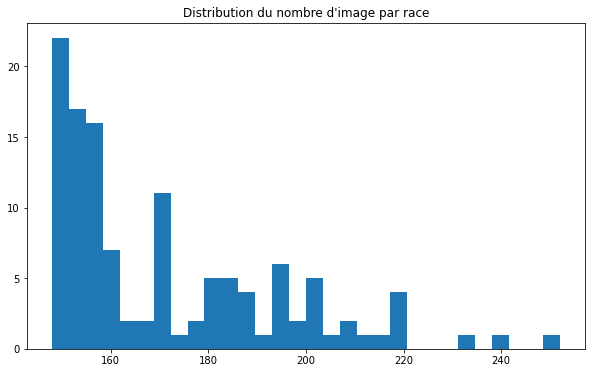

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(img_per_breed, bins=30)
plt.title('Distribution du nombre d\'image par race')
if env == 'local':
    plt.savefig(save_path + 'distri_img.png')
plt.show()

Nous constatons que la majorité des races comportent entre 140 et 160 photos.  
De plus nous n'avons pas de problématique d'une race qui ne comporterai pas suffisemment de photos.

In [7]:
print("Nombre minimum d'images dans une classe : {}".format(min(img_per_breed)))

Nombre minimum d'images dans une classe : 148


## 2.5 Echantillon d'images

In [8]:
def show_images_sample(nb_breed_to_show):
    '''show 4 firsts images of nb_breed_to_show breed choosen randomly'''

    nb_breed_to_show = int(nb_breed_to_show)

    plt.figure(figsize=(16,nb_breed_to_show*4))

    # fig.suptitle(breed, fontsize=20)
    for i in range(nb_breed_to_show):
        breed = random.choice(breed_list)
        img_dir = ini_img_dir + breed
        images = os.listdir(img_dir)[:4] # select 4 first images names

        for image_nb in range(4):
            plt.subplot(nb_breed_to_show, 4, (image_nb+1)+4*(i))
            img = mpimg.imread(img_dir + '/' + images[image_nb])
            plt.imshow(img)
            if image_nb == 0: # title only one the 1st image
                plt.title(breed)
            plt.axis('off')

    if env == 'local':
        plt.savefig(save_path + 'sample.png')

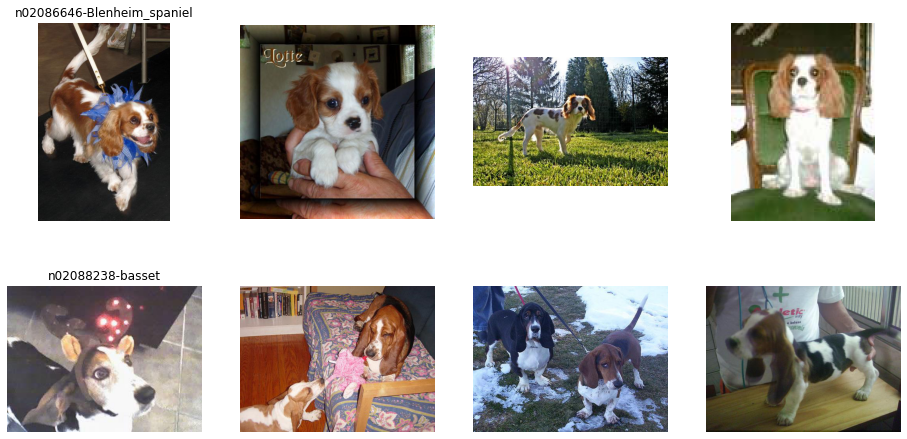

In [9]:
show_images_sample(2)

## 2.6 Filtre images corrompues

Nous travaillons avec de nombreuses données d'images du monde réel, les images corrompues sont un phénomène courant.  
Filtrons les images mal encodées qui ne comportent pas la chaîne "JFIF" dans leur en-tête.

Déterminons tout d'abord si nous avons des images corrompues.  

In [10]:
def filter_corrupted(initial_path, remove=False):
    num_skipped = 0
    for folder_name in os.listdir(initial_path):
        folder_path = os.path.join(initial_path, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                if remove:
                    os.remove(fpath)

    print("%d images corrompues" % num_skipped)

In [11]:
filter_corrupted(ini_img_dir)

10 images corrompues


Si ces images perturbent notre apprentissage ou préprocessing nous pourrons les supprimer.

# 3. Preprocessing

## 3.1 Resize / crop


Nous allons commencer par définir des fonctions permettant de changer la taille de nos images et de les recadrer grâces aux bounding box fournies avec le dataset.

In [12]:
def resize_img(img_path, height=height, width=width, bnd_box_annotations_path=None, method='pillow'):
    '''load and resize one image to height x width pixels return the image

    Parameters
    ------------------------------
    img_path :str
    bnd_box_annotations_path : str
        If bnd_box_annotations_path!=None it will select the proper box and then crop the image before the resize
    img_path : str
        image path and annotations must have the same subdirectories and files names (except for file extension)
    height, width : int
    method : str
        method could use opencv (as cv) instead of pillow (import Image)
    '''
    if method == 'opencv':
        img = cv.imread(img_path, cv.IMREAD_UNCHANGED)
    else:
        img = Image.open(img_path) # pillow library

    # this part extrat the bounding box dimensions from annotation folder
    if bnd_box_annotations_path!=None:
        path_no_extension = os.path.splitext(img_path)[0]
        file_name = os.path.split(path_no_extension)[1]
        # take the breed from the initial image path
        breed = os.path.split(os.path.split(path_no_extension)[0])[1]
        img_annotation_dir = bnd_box_annotations_path + '{}/{}'.format(breed, file_name)
        tree = ET.parse(img_annotation_dir)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)

        if method == 'opencv':
            img = img[ymin:ymax, xmin:xmax]
        else:
            img = img.crop((xmin, ymin, xmax, ymax))

    if method == 'opencv':
        img = cv.resize(img, (height, width), interpolation=cv.INTER_LINEAR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    else:
        img = img.convert('RGB')
        img = img.resize((height, width))
    return img

In [13]:
## Depreciated
# def all_dataset(function_to_apply, initial_path, saving_path, height=height, width=width, bnd_box_annotations_path=None):
#     '''apply a function to our entire dataset 
#     save new data to saving_path keeping same directories
#     '''
#     try:
#         os.mkdir(saving_path)
#     except FileExistsError:
#         pass

#     breed_list = os.listdir(initial_path)

#     for breed in breed_list:
#         breed_path = saving_path + breed
#         try:
#             os.mkdir(breed_path)
#         except FileExistsError:
#             pass

#         # list of img names with extentions
#         breed_file_list = os.listdir(initial_path + breed)

#         for file in breed_file_list:
#             img_path = initial_path + '{}/{}'.format(breed, file)
#             img = function_to_apply(img_path, height, width, bnd_box_annotations_path)
#             img.save(saving_path + '{}/{}'.format(breed, file))


In [14]:
## Depreciated
# all_dataset(resize_img, ini_img_dir, resized_dir) # depreciated since we don't need to store it, it's an argument on image loader
# all_dataset(resize_img, ini_img_dir, cropped_dir, bnd_box_annotations_path=bnd_box_annotations_path) # I will probably store the image in a variable strait after the cropping

In [15]:
## Depreciated
# filter_corrupted(resized_dir)
# filter_corrupted(cropped_dir)

In [16]:
def random_img(img_dir=ini_img_dir):
    '''return a random image path from our dataset'''
    breed_list = os.listdir(img_dir)
    breed = random.choice(breed_list)
    breed_path = img_dir + breed
    image = random.choice(os.listdir(breed_path))
    image_path = breed_path + '/' + image
    return image_path

In [17]:
def show_dif_size_img(ini_img_dir=ini_img_dir):

    image_path = random_img(ini_img_dir)

    fig = plt.figure(figsize=(16, 6))
    fig.suptitle('Images after size preprocessing', fontsize=16)

    # for i in range(3):
    plt.subplot(1, 3, 1)
    img = mpimg.imread(image_path)
    plt.title("Original shape : {}".format(img.shape))
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    img = resize_img(image_path, method='opencv')
    plt.title("Resized shape : {}".format(img.shape))
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    img = resize_img(image_path, bnd_box_annotations_path=bnd_box_annotations_path, method='opencv')
    plt.title("Cropped and resized shape : {}".format(img.shape))
    plt.imshow(img)
    plt.axis('off')
    
    if env == 'local':
        plt.savefig(save_path + 'size_preprocessing.png')

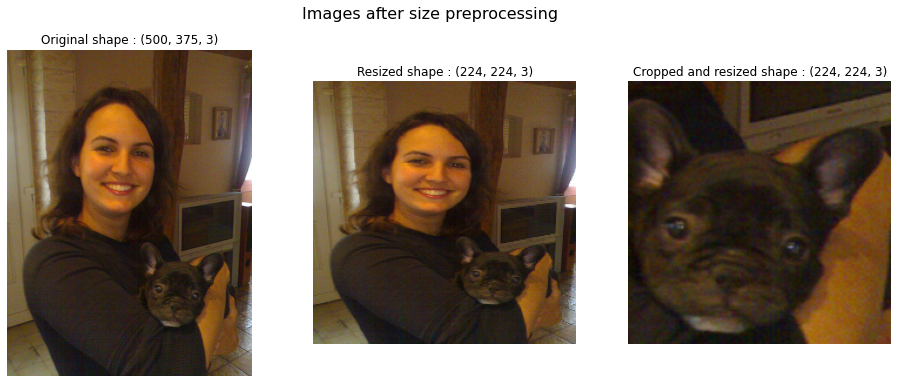

In [18]:
show_dif_size_img()

## 3.2 whitening

Dans les images naturelles, les pixels ont tendance à être corrélés avec leurs voisins.  
Le whitening supprime ces corrélations.

L'application du whitening PCA a pour effet de normaliser les images pour les écarts naturels.  
Cette normalisation améliore la précision des comparaisons que nous effectuons entre différentes parcelles d'image en utilisant la distance euclidienne.  
La distance entre les taches blanchies est une bien meilleure mesure de leur similitude que la distance entre les taches non blanchies. 

Nous utilisons d'abord l'ACP pour trouver les directions de variance et projeter les données dans ces directions.  
Ensuite, nous pouvons facilement normaliser la variance. 

L'étape de blanchiment effectue une extraction de caractéristiques qui, dans cet exemple, donne à la comparaison de distance une certaine invariance par rapport aux changements de luminosité.

<img src="..\img\pixel_4_5_correlation.png" width="400px"><img src="..\img\pixel_4_5_correlation_after_whiten.png" width="400px">    

Nous utiliserons le whitening à partir de la méthode Keras permettant de faire de la data augmentation.

## 3.3 histogram equalization

L'histogramme d'une image numérique est une courbe statistique représentant la répartition de ses pixels selon leur intensité.  
Commençons par regarder une image en particulier.

Nous allons transformer l'image dans différents codages couleurs.  
Le système de codage YUV est créé depuis une source RVB. Il est codé en trois composantes : 
- Y représente la luminance (informations de luminosité) 
- U et V sont des données de chrominance (informations de couleur).  
Ce format nous permet de visualiser au mieux l'histogramme pour les 3 dimensions.

**Egalisation**  
On constate régulièrement des pics importants de l'histogram.  
Dans le cadre d'une bonne égalisation (amélioration du contraste), il est nécessaire de répartir la lumière dans tout le spectre de l'image.

Nous utiliserons OpenCV pour l'égalisation.  
L'intérêt de convertir l'image dans l'espace colorimétrique YUV est de pouvoir agir sur le canal "luminance" (Y) indépendamment des autres canaux de chrominance.  
Nous allons donc réaliser l'égalisation sur ce seul canal Y

In [19]:
def equalize(img):
    '''initial and final image in RGB'''
    img_YUV = cv.cvtColor(img,cv.COLOR_RGB2YUV)
    img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
    img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
    return img_equ

In [20]:
def show_histo_img(img_dir=ini_img_dir):

    image_path = random_img(img_dir)

    fig = plt.figure(figsize=(16, 8))
    fig.suptitle('Images after equalization preprocessing', fontsize=16)
    fig.tight_layout()

    # for i in range(3):
    plt.subplot(2, 3, 1)
    img = mpimg.imread(image_path)
    plt.title("Original image")
    plt.imshow(img)

    plt.subplot(2, 3, 2)
    plt.title("Original image YUV")
    plt.imshow(cv.cvtColor(img,cv.COLOR_RGB2YUV))

    plt.subplot(2, 3, 3)
    plt.title("Original image histogram")
    vals = img.mean(axis=2).flatten()
    # plot histogram with 255 bins
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])

    plt.subplot(2, 3, 4)
    img = equalize(img)
    plt.title("Equalized image")
    plt.imshow(img)

    plt.subplot(2, 3, 5)
    plt.title("Equalized image YUV")
    plt.imshow(cv.cvtColor(img,cv.COLOR_RGB2YUV))

    plt.subplot(2, 3, 6)
    plt.title("Equalized image histogram")
    vals = img.mean(axis=2).flatten()
    # plot histogram with 255 bins
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])

    plt.axis('off')

    if env == 'local':
        plt.savefig(save_path + 'equalisation.png')

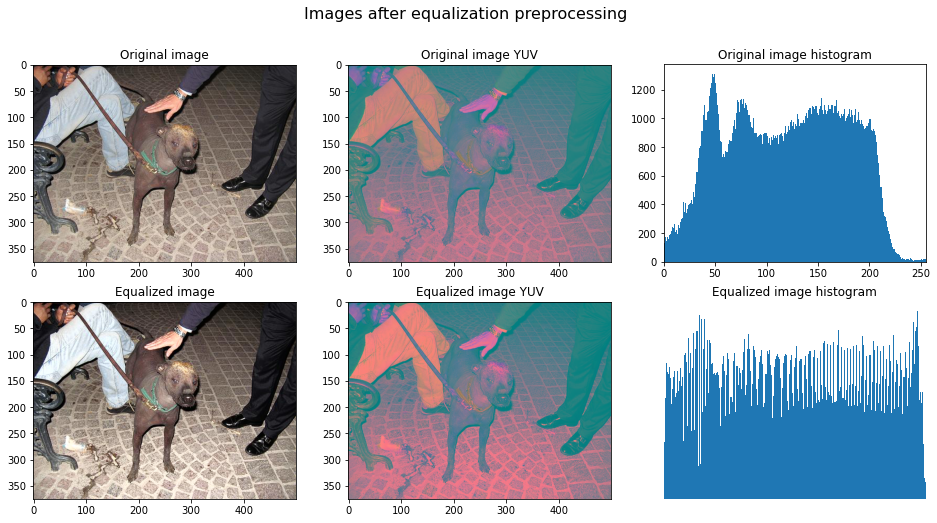

In [21]:
show_histo_img()

## 3.4 data augmentation

Le risque sur ce type de dataset comportant peu de données (20 000 images) est de sur-entrainer notre modèle.  
Il ne pourra pas développer des règles de décisions pouvant être généralisé à de nouvelles données.  
Il faut donc augmenter la quantité de data et pour cela, nous allons utiliser la Data Augmentation.

L'objectif de la data augmentation est d'augmenter artificiellement la quantité de données en leur appliquant une transformation aléatoire.  
Pour cela, Keras mets à disposition la méthode ImageDataGenerator qui permet de faire à la fois du mirroring, de la rotation, des zoom de manière aléatoire !

In [22]:
val_split = .2

In [23]:
def data_generator(val_split, zca_whitening=False, zca_epsilon=1e-06, normalize=False, preprocessing_function=None):
        '''return a ImageDataGenerator objetc from keras'''
        if normalize:
                rescale = 1./255
        else:
                rescale = None   

        data_gen = ImageDataGenerator(
                rescale=rescale,
                shear_range=0.2,
                rotation_range=30,
                zoom_range=0.1,
                brightness_range=[0.9,1.1],
                horizontal_flip=True,
                validation_split=val_split,
                zca_whitening=zca_whitening,
                zca_epsilon=zca_epsilon,
                preprocessing_function=preprocessing_function,
                )
        return data_gen

In [24]:
# We create 2 differents objects for the data augmentation
data_gen = data_generator(val_split, normalize=True)
data_gen_wh = data_generator(val_split, zca_whitening=True, normalize=True)

C:\Users\Admin\miniconda3\envs\env_p6\lib\site-packages\keras_preprocessing\image\image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [25]:
def show_data_gen(data_gen, img_dir=ini_img_dir):
    image_path = random_img(img_dir)
    img = mpimg.imread(image_path)

    # Convert test img to array
    x = keras.preprocessing.image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    fig = plt.figure(figsize=(12,10))
    fig.suptitle('Data Augmentation with Keras', fontsize=16)

    for i, batch in zip(range(12), data_gen.flow(x, batch_size=1)):
        ax = fig.add_subplot(3,4,i+1)
        ax.imshow(keras.preprocessing.image.array_to_img(batch[0]))
        plt.axis('off')

    if env == 'local':
        plt.savefig(save_path + 'distri_img.png')
    plt.show()

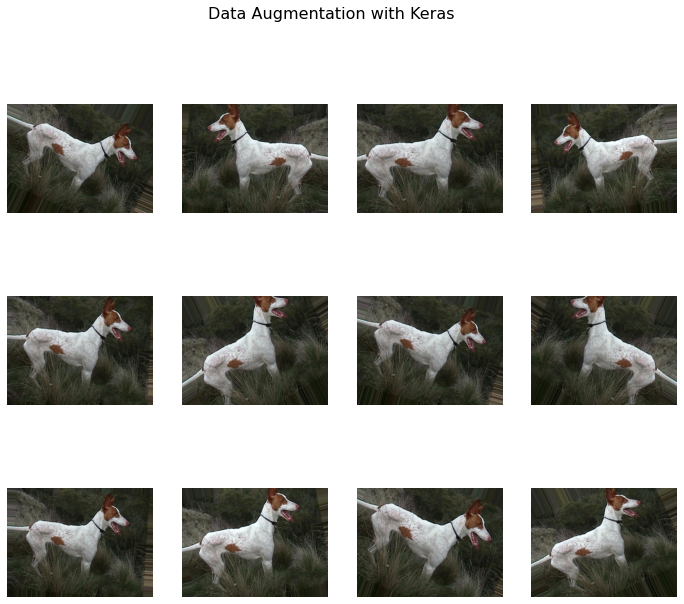

In [26]:
show_data_gen(data_generator(val_split))

## 3.5 Preprocessing final

Nous allons créer une fonction permettant de réaliser le préprocessing global.

Nous y inclueront une étape de mélange pour éviter que toutes nos races se suivents.

Les modèles de machine learning prennent en entrée des variables numériques de type float.  
Il faut donc modifier les types de nos données X et convertir nos données à prédire y.

Pour y nous allons donc utiliser un simple LabelEncoder pour les convertir.

In [27]:
# Define numbers of breeds to preprocess (from 2 to 120)
nb_breed = 3

In [28]:
def shuffle_Xy(X, y):
    # Using np.shuffle
    index = np.arange(X.shape[0])
    np.random.seed(42)
    # Shuffle the space
    np.random.shuffle(index)
    # Apply to X and y in same order
    X = X[index]
    y = y[index]
    return X, y

def change_type(X):
    # Change X type 
    return X.astype(np.float32)

def enc_label(y):
    # Encode y data
    encoder = LabelEncoder()
    encoder.fit(y)
    return encoder.transform(y)

In [29]:
def preprocessing_img(img_folder=ini_img_dir, height=height, width=width, bbx_annot=None, equalization=True, nb_breed=None):
    """Preprocessing of images in order to integrate them 
    into a convolutional neural network. 
    Loading, resizing, equalization and transformation of the image into Array. 
    Simultaneous creation of labels (y). 

    return X, y (numpy array)

    Parameters
    ---------------------------------------------------
    folder : str
        Initial folder with images
    width : integer
        width of the image to be reached for resizing
    height : integer
        height of the image to be reached for resizing
    bbx_annot : str
        path for annotation folder for bounding box crop
    equalization : bool
        activate or not the equalization
    nb_breed : int
        number of breeds to treat
        by default len(os.listdir(img_folder))
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    if nb_breed == None:
        nb_breed = len(os.listdir(img_folder))
        
    breeds = os.listdir(img_folder)[:nb_breed]
    for breed in breeds:
        for image_name in os.listdir(img_folder + "/" + breed):

            img_path = img_folder + "/" + breed + "/" + image_name

            # Resize image
            img = resize_img(img_path, height, width, bnd_box_annotations_path=bbx_annot, method='opencv')
            
            # Equalization
            if equalization:
                img = equalize(img)
            
            # Convert modified img to array
            img_array = keras.preprocessing.image.img_to_array(img)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])

    # Convert in numpy array
    X = np.array(img_list)
    y = np.array(labels)

    X, y = shuffle_Xy(X, y)
    X = change_type(X)
    y = enc_label(y)

    X, y = shuffle_Xy(X, y)
    X = change_type(X)
    y = enc_label(y)
    
    return X, y

In [30]:
# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels
X, y = preprocessing_img(img_folder=ini_img_dir, height=height, width=width, bbx_annot=None, equalization=True, nb_breed=nb_breed)

preprocess_time = timeit.default_timer() - start_time
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))
print("Total time : {:.2f}s".format(preprocess_time))

# we'll try also images cropped with annotations
start_time = timeit.default_timer()

X_crop, y_crop = preprocessing_img(img_folder=ini_img_dir, height=height, width=width, bbx_annot=bnd_box_annotations_path, equalization=True, nb_breed=nb_breed)

preprocess_time = timeit.default_timer() - start_time
print("-" * 50)
print("Execution time for preprocessing (cropped):")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y_crop)))
print("Shape of images np.array : {}"\
     .format(X_crop.shape))
print("Total time : {:.2f}s".format(preprocess_time))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 589
Shape of images np.array : (589, 224, 224, 3)
Total time : 2.67s
--------------------------------------------------
Execution time for preprocessing (cropped):
--------------------------------------------------
Number of images preprocessed : 589
Shape of images np.array : (589, 224, 224, 3)
Total time : 2.95s


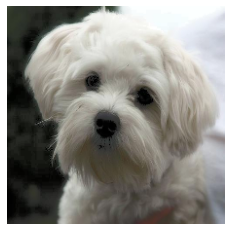

In [31]:
# sample
plt.imshow(keras.preprocessing.image.array_to_img(X[random.randint(0, 100)]))
plt.axis('off')
plt.show()

A présent, nous pouvons créer les sets d'entrainement et de test qui serviront respectivement à l'entrainement de nos modèles et à son test final.  
Le set de validation quant à lui sera créé directement dans le générateur Keras.

In [32]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
x_train_crop, x_test_crop, y_train_crop, y_test_crop = train_test_split(X_crop, y_crop, test_size = 0.15, random_state = 42)

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
Train set size =  500
Test set size =  89



# 4. CNN spécifique

Nous allons tout d'abord créer un réseau de neuronne convolutif entier avant de l'entrainer et de le tester


## 4.1 Création du model

Nous allons ici initialiser un premier modèle de réseau de neurones à convolution en imbriquant plusieurs couches ou layer :

- **Convolution** : Son but est de repérer la présence d'un ensemble de features dans les images reçues en entrée. Pour cela, on réalise un filtrage par convolution.
- **Pooling** : L'opération de pooling consiste à réduire la taille des images, tout en préservant leurs caractéristiques importantes.
- **Correction ReLU** : La couche de correction ReLU remplace toutes les valeurs négatives reçues en entrées par des zéros. Elle joue le rôle de fonction d'activation.
- **Fully connected** : Ce type de couche reçoit un vecteur en entrée et produit un nouveau vecteur en sortie. Pour cela, elle applique une combinaison linéaire puis éventuellement une fonction d'activation aux valeurs reçues en entrée.
- **DropOut** : La méthode du dropout consiste à « désactiver » des sorties de neurones aléatoirement pour éviter le sur-entraînement.

Pour notre modèle, nous allons tester une architecture simple, assez peu profonde qui nous servira de baseline pour les prochains modèles.  
Nous allons donc implémenter uniquement 3 couches de convolution.



In [33]:
def make_model(nb_breed=nb_breed, height=height, width=width, optimizer='adam',metrics=["accuracy"], summary=True):
    '''Create a simple sequential model

    parameters
    ------------------
    nb_breed : int
        number of breed to classify
    height, width : int
    optimizer : str
        from tf.keras.optimizers
    metrics : list
    summary : Bool
    '''
    K.clear_session()
    model = Sequential()
    # Convolution layer
    model.add(Conv2D(filters=16,
                    kernel_size=(3,3), 
                    padding='same',
                    use_bias=False,
                    input_shape=(height, width,3))) # we don't need to add an input because of this line
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation('relu'))
    # Pooling layer
    model.add(MaxPooling2D(pool_size=(4, 4),
                        strides=(4, 4),
                        padding='same'))
    # DropOut
    model.add(Dropout(0.2))
    # Second convolution layer
    model.add(Conv2D(filters=32,
                    kernel_size=(3,3), 
                    padding='same',
                    use_bias=False))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
    model.add(Dropout(0.2))
    # Third convolution layer
    model.add(Conv2D(filters=64,
                    kernel_size=(3,3), 
                    padding='same',
                    use_bias=False))
    model.add(BatchNormalization(axis=3, scale=False))
    model.add(Activation('relu'))
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(128, activation='relu'))

    if nb_breed == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = nb_breed

    model.add(Dropout(0.2))
    model.add(Dense(units, activation=activation))

    if nb_breed == 2:
        loss="binary_crossentropy"
    else:
        loss="sparse_categorical_crossentropy"

    # Compile the CNN Model
    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    if summary:
        model.summary()
    return model

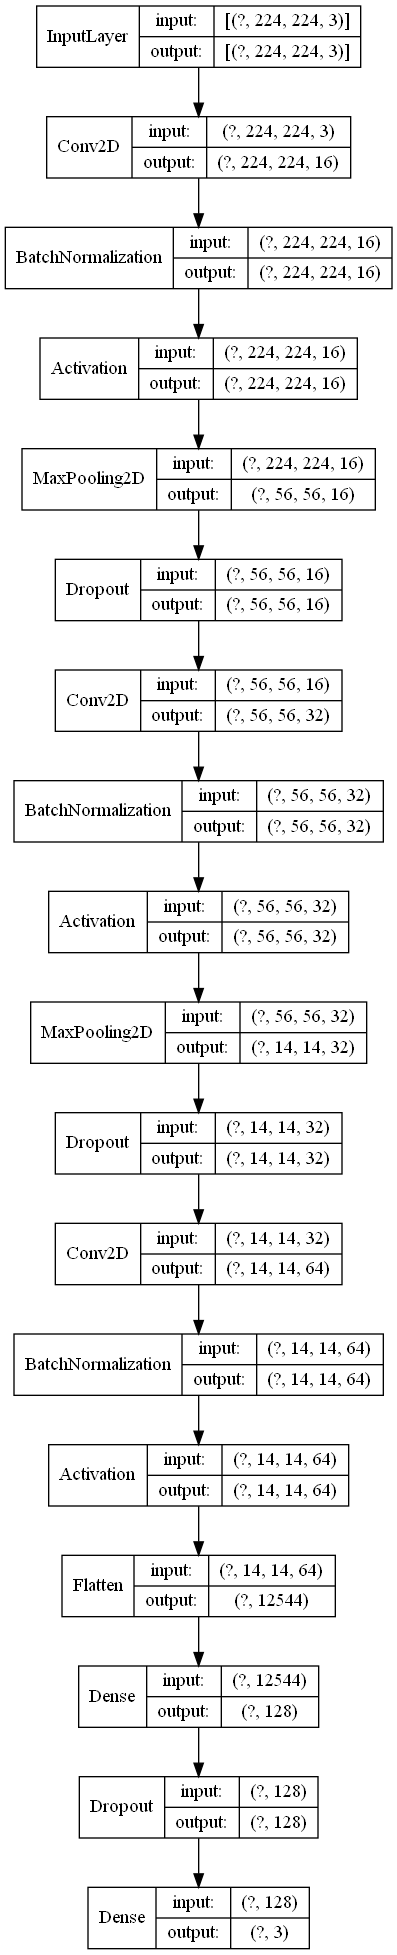

In [45]:
model = make_model(optimizer='adam',metrics=["accuracy"], summary=False)
if env == 'local':
    display(plot_model(model,
        to_file=save_path + 'model_scratch.png',
        show_shapes=True,
        show_layer_names=False))

## 4.2 Evaluation

Nous utiliserons pour l'évaluation la "Loss-Function" et l'"Accuracy".  
Il s'agit de façon équivalente de diminuer la première ou d'augmenter la seconde.

<!-- Nous allons également définir le Score F1 qui combine precision et recall :

La précision est utilisée lorsque les vrais positifs et les vrais négatifs sont plus importants tandis que le score F1 est utilisé lorsque les faux négatifs et les faux positifs sont cruciaux
La précision peut être utilisée lorsque la distribution des classes est similaire, tandis que le score F1 est une meilleure mesure lorsqu'il existe des classes déséquilibrées comme dans le cas ci-dessus.

Dans la plupart des problèmes de classification de la vie réelle, une distribution de classe déséquilibrée existe et le score F1 est donc une meilleure mesure pour évaluer notre modèle. -->

In [36]:
score_f1_activate = False

if score_f1_activate:

    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [37]:
def plot_history_scores(dict_history, first_score, second_score=None):
    '''plot scores from history dic created by keras'''
    with plt.style.context('seaborn-whitegrid'):

        # summarize history for accuracy
        if second_score:
            fig = plt.figure(figsize=(14, 6))
            plt.subplot(1, 2, 1)
        else:
            fig = plt.figure(figsize=(8, 6))

        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=14)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        if second_score:
            # summarize history for loss
            plt.subplot(1, 2, 2)
            plt.plot(dict_history.history[second_score], color="g")
            plt.plot(dict_history.history['val_' + second_score],
                    linestyle='--', color="orange")
            plt.title('CNN model ' + second_score, fontsize=14)
            plt.ylabel(second_score)
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')

        if env == 'local':
            plt.savefig(save_path + 'score_graph.png')

        plt.show()

## 4.3 Entrainement

Nous allons maintenant entrainer et évaluer notre modèle.  
Nous testerons 2 optimizers différents ainsi que l'effet du whitening sur nos résultats.

In [38]:
epochs = 20
batch_size = 32

In [39]:
score_dic = {}

def model_eval_store(model, x_test, y_test, dic, model_name, time, history):

    test_loss, test_acc = model.evaluate(x_test, y_test)  # returns loss and metrics
    print("loss: %.2f" % test_loss)
    print("acc: %.2f" % test_acc)
    
    dic[model_name] = [round(max(history.history['accuracy']), 2),
        round(max(history.history['val_accuracy']), 2),
        round(test_acc, 2),
        round(time, 2)]

In [48]:
def model_tester(x_train, y_train, x_test, y_test, optimizer, data_gen, model_name, model=None):
        '''automation of the model creation, compiling, fitting and evaluate'''
        start_time = timeit.default_timer()

        if model is None:
                model = make_model(optimizer=optimizer,metrics=["accuracy"], plot=False, summary=False)

        train_ds = data_gen.flow(
                x_train, y_train,
                batch_size=batch_size,
                subset='training')

        val_ds = data_gen.flow(
                x_train, y_train,
                batch_size=batch_size,
                subset='validation')

        early_stopping_monitor = EarlyStopping(patience=5)

        history = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs=epochs,
                callbacks = [early_stopping_monitor],
                verbose=2)


        plot_history_scores(
                dict_history = history, 
                first_score = "accuracy")
        
        convergence_time = timeit.default_timer() - start_time

        model_eval_store(model, x_test, y_test, score_dic, model_name, convergence_time, history)
        return model

Imrovement : save the model in a file

Epoch 1/20
13/13 - 11s - loss: 4.2064 - accuracy: 0.3600 - val_loss: 1.0958 - val_accuracy: 0.3900
Epoch 2/20
13/13 - 10s - loss: 1.2545 - accuracy: 0.4725 - val_loss: 1.1340 - val_accuracy: 0.3900
Epoch 3/20
13/13 - 10s - loss: 0.9432 - accuracy: 0.5400 - val_loss: 1.2835 - val_accuracy: 0.3900
Epoch 4/20
13/13 - 11s - loss: 0.9168 - accuracy: 0.5425 - val_loss: 1.5091 - val_accuracy: 0.3900
Epoch 5/20
13/13 - 10s - loss: 0.8864 - accuracy: 0.6150 - val_loss: 1.5427 - val_accuracy: 0.3900
Epoch 6/20
13/13 - 11s - loss: 0.8639 - accuracy: 0.6325 - val_loss: 1.5418 - val_accuracy: 0.3900


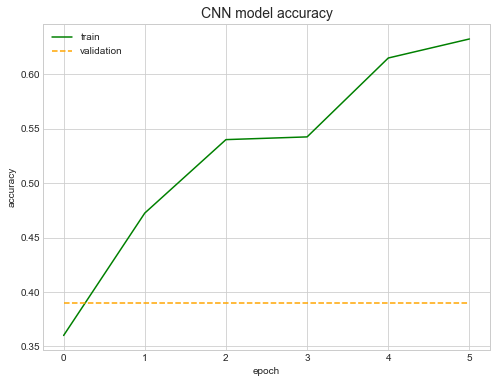

3/3 [==============================] - 0s 66ms/step - loss: 1.0905 - accuracy: 0.3371
loss: 1.09
acc: 0.34
Epoch 1/20
13/13 - 10s - loss: 2.6790 - accuracy: 0.4200 - val_loss: 1.0786 - val_accuracy: 0.3900
Epoch 2/20
13/13 - 10s - loss: 0.9058 - accuracy: 0.5550 - val_loss: 1.0708 - val_accuracy: 0.3900
Epoch 3/20
13/13 - 10s - loss: 0.7546 - accuracy: 0.6575 - val_loss: 1.0909 - val_accuracy: 0.3900
Epoch 4/20
13/13 - 9s - loss: 0.7857 - accuracy: 0.6425 - val_loss: 1.1016 - val_accuracy: 0.3900
Epoch 5/20
13/13 - 10s - loss: 0.6855 - accuracy: 0.7175 - val_loss: 1.1839 - val_accuracy: 0.3900
Epoch 6/20
13/13 - 9s - loss: 0.7108 - accuracy: 0.7075 - val_loss: 1.2867 - val_accuracy: 0.3900
Epoch 7/20
13/13 - 10s - loss: 0.6527 - accuracy: 0.7125 - val_loss: 1.3111 - val_accuracy: 0.3900


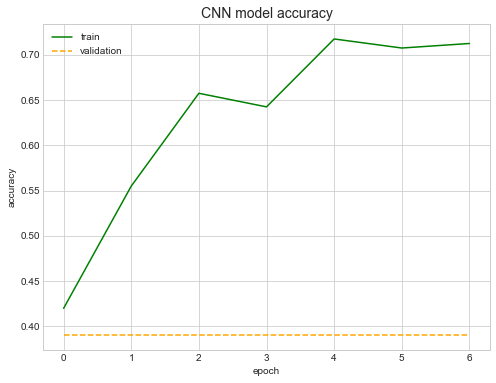

3/3 [==============================] - 0s 58ms/step - loss: 99.2733 - accuracy: 0.2921
loss: 99.27
acc: 0.29


C:\Users\Admin\miniconda3\envs\env_p6\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Admin\miniconda3\envs\env_p6\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
13/13 - 10s - loss: 3.6083 - accuracy: 0.3950 - val_loss: 1.0806 - val_accuracy: 0.3900
Epoch 2/20
13/13 - 9s - loss: 1.1488 - accuracy: 0.5550 - val_loss: 1.1041 - val_accuracy: 0.3900
Epoch 3/20
13/13 - 10s - loss: 0.9407 - accuracy: 0.5375 - val_loss: 1.2691 - val_accuracy: 0.3900
Epoch 4/20
13/13 - 10s - loss: 0.8978 - accuracy: 0.5800 - val_loss: 1.4180 - val_accuracy: 0.3900
Epoch 5/20
13/13 - 9s - loss: 0.8727 - accuracy: 0.6150 - val_loss: 1.6222 - val_accuracy: 0.3900
Epoch 6/20
13/13 - 9s - loss: 0.8055 - accuracy: 0.6250 - val_loss: 2.0605 - val_accuracy: 0.3900


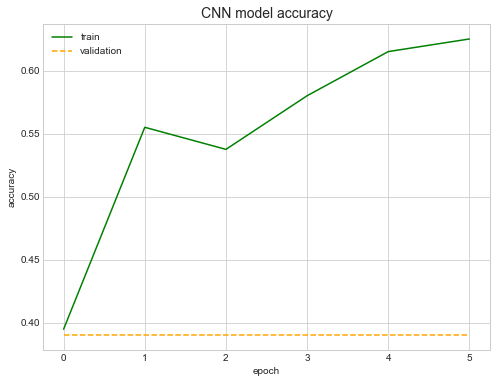

3/3 [==============================] - 0s 66ms/step - loss: 19.1579 - accuracy: 0.4045
loss: 19.16
acc: 0.40
Epoch 1/20
13/13 - 10s - loss: 6.4549 - accuracy: 0.4125 - val_loss: 1.0755 - val_accuracy: 0.4600
Epoch 2/20
13/13 - 9s - loss: 1.3280 - accuracy: 0.4775 - val_loss: 1.1406 - val_accuracy: 0.3900
Epoch 3/20
13/13 - 10s - loss: 0.9442 - accuracy: 0.5650 - val_loss: 1.2525 - val_accuracy: 0.3900
Epoch 4/20
13/13 - 11s - loss: 0.9829 - accuracy: 0.5250 - val_loss: 1.1527 - val_accuracy: 0.3900
Epoch 5/20
13/13 - 13s - loss: 0.9073 - accuracy: 0.6050 - val_loss: 1.4194 - val_accuracy: 0.3900
Epoch 6/20
13/13 - 10s - loss: 0.8644 - accuracy: 0.6000 - val_loss: 1.2728 - val_accuracy: 0.3900


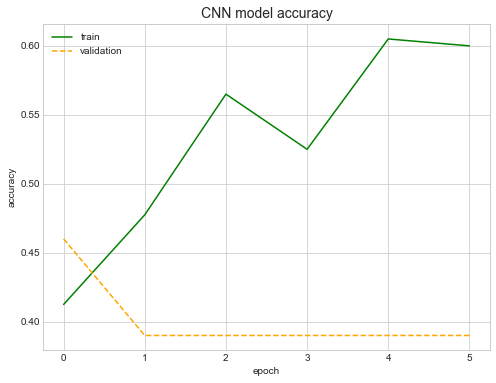

3/3 [==============================] - 0s 54ms/step - loss: 15.7396 - accuracy: 0.4831
loss: 15.74
acc: 0.48


(<tensorflow.python.keras.engine.sequential.Sequential at 0x1d7811a2e50>,
 <tensorflow.python.keras.callbacks.History at 0x1d78137f190>)

In [68]:
# baseline
model_tester(x_train, y_train, x_test, y_test,
    optimizer='adam',
    data_gen=data_gen,
    model_name='baseline')

# images copped
model_tester(x_train_crop, y_train_crop, x_test_crop, y_test_crop,
    optimizer='adam',
    data_gen=data_gen,
    model_name='cropped')

# testing whitening
model_tester(x_train, y_train, x_test, y_test,
    optimizer='adam',
    data_gen=data_gen_wh,
    model_name='whitening')

# testing a different optimizer
model_tester(x_train, y_train, x_test, y_test,
    optimizer='RMSprop',
    data_gen=data_gen,
    model_name='RMSprop')

In [42]:
def plot_history(score_dic=score_dic):
    labels = score_dic.keys()

    train_accuracy = [score[0] for score in score_dic.values()]
    val_accuracy = [score[1] for score in score_dic.values()]
    test_accuracy = [score[2] for score in score_dic.values()]
    time = [score[3] for score in score_dic.values()]

    width_plt = 0.3  # the width of the bars
    x = np.arange(len(labels))  # the label locations
    graph_width = 4 * len(score_dic)
    with plt.style.context('seaborn-whitegrid'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(graph_width,8))


        train = ax1.bar(x - width_plt, train_accuracy, width_plt, label='Train')
        val = ax1.bar(x , val_accuracy, width_plt, label='Val')
        test = ax1.bar(x + width_plt, test_accuracy, width_plt, label='Test')

        time_model = ax2.bar(x, time, 2*width_plt, label='Time')

        ax1.set_title('Accuracy (higher is better)')
        ax1.set_ylabel('Scores')
        ax1.set_xticks(x)
        ax1.set_xticklabels(labels)
        ax1.legend()

        ax2.set_title('Time (lower is better)')
        ax2.set_ylabel('Seconds')
        ax2.set_xticks(x)
        ax2.set_xticklabels(labels)


C:\Users\Admin\miniconda3\envs\env_p6\lib\site-packages\matplotlib\tight_bbox.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
C:\Users\Admin\miniconda3\envs\env_p6\lib\site-packages\matplotlib\tight_bbox.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
C:\Users\Admin\miniconda3\envs\env_p6\lib\site-packages\matplotlib\patches.py:778: RuntimeWarning: invalid value encountered in double_scalars
  self._x1 = self._x0 + self._width
C:\Users\Admin\miniconda3\envs\env_p6\lib\site-packages\matplotlib\transforms.py:1977: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx


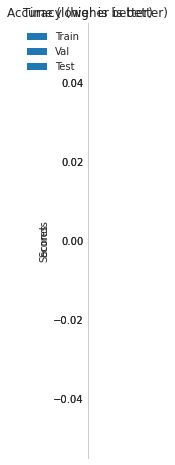

In [57]:
plot_history(score_dic)

In [ ]:
# # Run inference on new data

# img = keras.preprocessing.image.load_img(
#     "PetImages/Cat/6779.jpg", target_size=image_size
# )
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# predictions = model.predict(img_array)
# score = predictions[0]
# print(
#     "This image is %.2f percent cat and %.2f percent dog."
#     % (100 * (1 - score), 100 * score)
# )

# 5. Transfert learning

Nous allons maintenant tester des modèles pré-entrainés et vérifier si les performances sont meilleures comparées à notre baseline.

## 5.1 VGG16 

Chargeons le modèle de base pré-entrainé de Keras mais sans les couches fully-connected.  
Nous allons ajouter notre propre classifier final.

In [49]:
K.clear_session()

# model = tf.keras.applications.VGG16()

inputs = keras.Input(shape=(height, width, 3))
model_vgg16 =  tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    pooling='avg'
)

In [50]:
for layer in model_vgg16.layers[-2:]:
    print(layer)

In [51]:
# For imported layers we'll keep the weights
for layer in model_vgg16.layers:
    layer.trainable = False

On remarque dans les layers importés du modèle que la dernière couche importée est une couche GlobalAveragePooling2D. 

Nous allons donc ajouter une couche fully connected, un DropOut et enfin le classifier dans un nouveau modèle.

In [54]:
def make_model_TL(model,model_name=None, out_dense=128, dropout=0.2):

      # For imported layers we'll keep the weights
      for layer in model.layers:
            layer.trainable = False

      base_output = model.output
      # fully connected
      output = Dense(out_dense, activation='relu')(base_output)
      # dropout
      output = Dropout(dropout)(output)
      # classifier
      output = Dense(nb_breed, activation='softmax')(output)

      # Define new model
      model = keras.Model(inputs=model.input,
                        outputs=output)
      model.compile(optimizer="adam",
                        loss="sparse_categorical_crossentropy",
                        metrics=["accuracy"])

      if env == 'local' and model_name is not None:
            display(plot_model(model,
                  to_file=save_path + model_name +'.png',
                  show_shapes=True,
                  show_layer_names=False))
      return model

In [55]:
model_vgg16 = make_model_TL(model_vgg16, 'vgg16')
data_gen_vgg16 = data_generator(val_split, normalize=True, preprocessing_function=tf.keras.applications.vgg16.preprocess_input,)

In [56]:
model_tester(x_train, y_train, x_test, y_test, 'adam', data_gen_vgg16, 'vgg16', model=model_vgg16)

# train_ds = data_gen_vgg.flow(
#         x_train, y_train,
#         batch_size=batch_size,
#         subset='training')

# val_ds = data_gen_vgg.flow(
#         x_train, y_train,
#         batch_size=batch_size,
#         subset='validation')

# early_stopping_monitor = EarlyStopping(patience=5)

# history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=epochs,
#         callbacks = [early_stopping_monitor],
#         verbose=2)

Epoch 1/20


KeyboardInterrupt: 

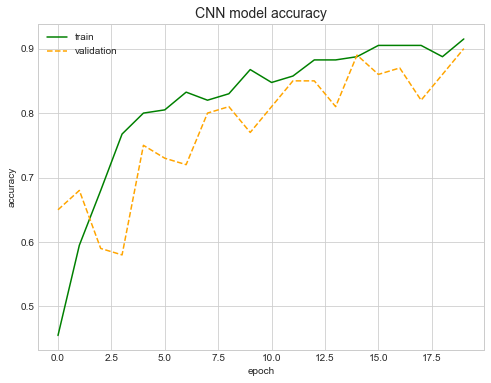

In [33]:
# plot_history_scores(
#         dict_history = history, 
#         first_score = "accuracy")

In [49]:
# loss, acc  = model.evaluate(x_test, y_test)  # returns loss and metrics
# print("loss: %.2f" % loss)
# print("acc: %.2f" % acc)
# # print("f1: %.2f" % f1)

3/3 [==============================] - 3s 1s/step - loss: 18.1583 - accuracy: 0.2584
loss: 18.16
acc: 0.26


## 5.2 Xception

In [44]:
K.clear_session()

inputs = keras.Input(shape=(299, 299, 3))

model_xception = keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    pooling='avg'
)

In [45]:
for layer in model_xception.layers[-2:]:
    print(layer)

In [46]:
model_xception = make_model_TL(model_xception, 'xception')

On remarque dans les layers importés du modèle que la dernière couche importée est une couche GlobalAveragePooling2D. 

Nous allons donc ajouter une couche fully connected, un DropOut et enfin le classifier dans un nouveau modèle.

In [31]:
data_gen_xception = data_generator(val_split, normalize=True, preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [ ]:
# we preprocess images again because Xception need 299*299 images
X, y = preprocessing_img(img_folder=ini_img_dir, height=height, width=width, bbx_annot=None, equalization=True, nb_breed=nb_breed)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [32]:
model_tester(x_train, y_train, x_test, y_test, 'adam', data_gen_xception, 'xception', model=model_xception)

# train_ds = data_gen_xception.flow(
#         x_train, y_train,
#         batch_size=batch_size,
#         subset='training')

# val_ds = data_gen_xception.flow(
#         x_train, y_train,
#         batch_size=batch_size,
#         subset='validation')

# early_stopping_monitor = EarlyStopping(patience=5)

# history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=epochs,
#         callbacks = [early_stopping_monitor],
#         verbose=2)

Epoch 1/20
13/13 - 50s - loss: 1.0801 - accuracy: 0.4550 - val_loss: 0.9743 - val_accuracy: 0.6500
Epoch 2/20
13/13 - 47s - loss: 0.9088 - accuracy: 0.5950 - val_loss: 0.8879 - val_accuracy: 0.6800
Epoch 3/20
13/13 - 48s - loss: 0.7975 - accuracy: 0.6800 - val_loss: 0.8128 - val_accuracy: 0.5900
Epoch 4/20
13/13 - 47s - loss: 0.6965 - accuracy: 0.7675 - val_loss: 0.7911 - val_accuracy: 0.5800
Epoch 5/20
13/13 - 51s - loss: 0.6307 - accuracy: 0.8000 - val_loss: 0.6676 - val_accuracy: 0.7500
Epoch 6/20
13/13 - 51s - loss: 0.5796 - accuracy: 0.8050 - val_loss: 0.6221 - val_accuracy: 0.7300
Epoch 7/20
13/13 - 49s - loss: 0.5024 - accuracy: 0.8325 - val_loss: 0.6322 - val_accuracy: 0.7200
Epoch 8/20
13/13 - 52s - loss: 0.4740 - accuracy: 0.8200 - val_loss: 0.5574 - val_accuracy: 0.8000
Epoch 9/20
13/13 - 53s - loss: 0.4653 - accuracy: 0.8300 - val_loss: 0.5423 - val_accuracy: 0.8100
Epoch 10/20
13/13 - 55s - loss: 0.4149 - accuracy: 0.8675 - val_loss: 0.5421 - val_accuracy: 0.7700
Epoch 11/

## 5.3 transfert learning evaluation

In [ ]:
plot_history(score_dic)

# 6. Application


# 7. Conclusion et résultats